In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!nvidia-smi

Sun May 22 05:13:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
pip install underthesea

     |████████████████████████████████| 7.6 MB 10.6 MB/s 
     |████████████████████████████████| 581 kB 6.0 MB/s 
     |████████████████████████████████| 965 kB 5.3 MB/s 
     |████████████████████████████████| 235 kB 59.2 MB/s 


In [88]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.vi.vec

--2022-05-22 05:51:34--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.vi.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 764348395 (729M) [binary/octet-stream]
Saving to: ‘wiki.vi.vec’

wiki.vi.vec         100%[===================>] 728.94M  4.77MB/s    in 3m 54s  

2022-05-22 05:55:29 (3.12 MB/s) - ‘wiki.vi.vec’ saved [764348395/764348395]



In [4]:
%tensorflow_version 2.x

In [5]:
import pandas as pd
from itertools import chain
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import io
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import string
import re
from os.path import join
from underthesea import sent_tokenize,word_tokenize,pos_tag
from sklearn.metrics import *
from sklearn.utils.class_weight import compute_class_weight

In [6]:
train=pd.read_csv("/content/drive/MyDrive/vietnamese_students_feedback/raw_dataset/train.csv")

In [7]:
valid=pd.read_csv("/content/drive/MyDrive/vietnamese_students_feedback/raw_dataset/valid.csv")

In [8]:
train

,sentence,sentiment,topic
0,slide giáo trình đầy đủ .,2,1
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",2,0
2,đi học đầy đủ full điểm chuyên cần .,0,1
3,chưa áp dụng công nghệ thông tin và các thiết ...,0,0
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",2,0
...,...,...,...
11421,chỉ vì môn game mà em học hai lần mà không qua...,0,1
11422,em cảm ơn cô nhiều .,2,0
11423,giao bài tập quá nhiều .,0,0
11424,"giáo viên dạy dễ hiểu , nhiệt tình .",2,0


In [9]:
punctuations=list(string.punctuation)
def normalizer(text,joinf=False):
  def remove_symbols(s):
    return re.sub(r'\b(colon\w+)\b'," ",s)

  def remove_fraction(s):
    return re.sub(r'\b(fraction)\b','/',s)

  def replace_dot(s):
    return s.replace('dot','.')
    # return re.sub(r'\b(dot)\b',".",s)

  def replace_doubledot(s):
    return s.replace('doubledot',':')
    
  def uncased(s):
    return s.lower()

  def fix_whitespaces(s):
    return re.sub(r'\s+',' ',s)

  def remove_entities(s):
    return re.sub(r'\b((\w+|)wzjwz\d+)\b'," ",s)

  def remove_vv(s):
    return s.replace('v.v'," ")

  def remove_punctuations(s):
      return ''.join(ch for ch in s if ch not in punctuations)
  def norm_major(s):
      majors={
          'cnpm':"công nghệ phần mềm",
          'khmt':"khoa học máy tính",
          'ktmt':"kĩ thuật máy tính",
          'cntt':"công nghệ thông tin",
          'av1':"anh văn 1",
          'av2':"anh văn 2",
          'av3':"anh văn 3"
      }
      for k,v in majors.items():
        s=re.sub(r'\b({})\b'.format(k),v,s)
      return s
  def remove_ps(s):
    return s.replace("p / s"," ")

  def tokenizer(text):
    tokens=[]
    pos_tags=[]
    for sent in sent_tokenize(text):
      tags=pos_tag(sent)
      for token in tags:
        if token[0] not in punctuations:
          tokens.append(uncased(token[0]))
          pos_tags.append(token[1])
    return {'tokens':tokens,'pos_tags':pos_tags}

  norm_text=fix_whitespaces(norm_major(remove_ps(remove_fraction(remove_vv(remove_entities(remove_symbols(replace_dot(replace_doubledot(text)))))))).strip())
  return tokenizer(norm_text)

In [10]:
train_x=train['sentence'].tolist()
train_y=train['topic'].tolist()

In [11]:
train_x=[normalizer(sample)for sample in train_x]

In [12]:
max_length=max([len(s['tokens'])  for s in train_x])
max_length

111

In [13]:
all_tokens=[s['tokens'] for s in train_x]

In [14]:
all_tokens=list(chain.from_iterable(all_tokens))

In [15]:
tokens=['pad','unk']
for token in all_tokens:
  if token not in tokens:
    tokens.append(token)

In [16]:
len(tokens)

3465

In [17]:
token2idx={token:idx for idx,token in enumerate(tokens)}

In [18]:
token2idx['pad']

0

In [19]:
all_pos_tags=[s['pos_tags'] for s in train_x]

In [20]:
all_pos_tags=list(chain.from_iterable(all_pos_tags))

In [21]:
pos_tags=['pad','unk']
for tag in all_pos_tags:
  if tag not in pos_tags:
    pos_tags.append(tag)

In [22]:
len(pos_tags)

19

In [23]:
pos_tag2idx={tag:idx for idx,tag in enumerate(pos_tags)}

In [24]:
tokens_train_x=[s['tokens'] for s in train_x]
pos_tags_train_x=[s['pos_tags'] for s in train_x]

In [25]:
tokens_train_x=[[token2idx[token] for token in s] for s in tokens_train_x]
pos_tags_train_x=[[pos_tag2idx[token] for token in s] for s in pos_tags_train_x]

In [26]:
tokens_train_x = tf.keras.preprocessing.sequence.pad_sequences(
    tokens_train_x, padding="post",maxlen=128)

pos_tags_train_x = tf.keras.preprocessing.sequence.pad_sequences(
    pos_tags_train_x, padding="post",maxlen=128)

In [27]:
tokens_train_x[1]

array([5, 6, 7, 8, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [28]:
pos_tags_train_x[1]

array([2, 3, 3, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [29]:
def create_input_ids(sample):
  _tokens=[]
  _pos_tags=[]
  tokens=normalizer(sample)

  for i in zip(tokens['tokens'],tokens['pos_tags']):

    if i[0] in token2idx:
      _tokens.append(token2idx[i[0]])
    else:
      _tokens.append(token2idx['unk'])

    if i[1] in pos_tag2idx:
      _pos_tags.append(pos_tag2idx[i[1]])
    else:
      _pos_tags.append(pos_tag2idx['unk'])

  return {'tokens':_tokens,'pos_tags':_pos_tags}

In [30]:
valid_x=valid['sentence'].tolist()
valid_y=valid['topic'].tolist()

In [31]:
valid_x=[create_input_ids(s) for s in valid_x]

In [32]:
tokens_valid_x=[s['tokens'] for s in valid_x]
pos_tags_valid_x=[s['pos_tags'] for s in valid_x]

In [33]:
tokens_valid_x = tf.keras.preprocessing.sequence.pad_sequences(
    tokens_valid_x, padding="post",maxlen=128)

pos_tags_valid_x = tf.keras.preprocessing.sequence.pad_sequences(
    pos_tags_valid_x, padding="post",maxlen=128)

In [115]:
train_batch_size=32
train_dataloader=tf.data.Dataset.from_tensor_slices({'input_ids':tokens_train_x,'pos_tag_ids':pos_tags_train_x,'labels':train_y})
train_dataloader=train_dataloader.batch(batch_size=train_batch_size)

In [116]:
valid_batch_size=32
valid_dataloader=tf.data.Dataset.from_tensor_slices({'input_ids':tokens_valid_x,'pos_tag_ids':pos_tags_valid_x,'labels':valid_y})
valid_dataloader=valid_dataloader.batch(batch_size=valid_batch_size)

In [117]:
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float, tokens[1:]))
    return data

vectors={}
vectors=load_vectors("/content/wiki.vi.vec")

token2vector={}
for token in tokens:
  vector=np.random.uniform(low=0,high=0.2,size=(1,300))
  if token in vectors:
    # if len(vector)!=300:
    #   print(vectors[token][:10])
    vector=np.array([vectors[token]])

  token2vector[token]=vector

weights=np.concatenate(list(token2vector.values()),axis=0)
weights=tf.keras.initializers.Constant(weights)

In [118]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [119]:
LSTM_Layer = tf.compat.v1.keras.layers.CuDNNLSTM if tf.test.gpu_device_name()!="" else layers.LSTM
LSTM_Layer


keras.layers.cudnn_recurrent.CuDNNLSTM

In [120]:
class BiLSTMClassificier(tf.keras.Model):
  def __init__(self,embedding_dim,hidden_dim,num_vocabs,num_pos_tags=None,drop_rate=0.1,embedding_weights=None):
    super(BiLSTMClassificier,self).__init__()

    self.embedding_dim=embedding_dim
    self.hidden_dim=hidden_dim
    self.num_vocabs=num_vocabs
    self.num_labels=num_labels
    self.drop_rate=drop_rate
    self.embedding_weights=embedding_weights
    self.num_pos_tags=num_pos_tags

    if self.embedding_weights!=None:
      self.token_embedding_layer=layers.Embedding(self.num_vocabs,self.embedding_dim,embeddings_initializer=self.embedding_weights,trainable=True)#,mask_zero=True)
    else:
      self.token_embedding_layer=layers.Embedding(self.num_vocabs,self.embedding_dim,trainable=True)#,mask_zero=True)
    if self.num_pos_tags!=None:
      self.pos_tag_embedding_layer=layers.Embedding(self.num_pos_tags,self.embedding_dim,trainable=True)#,mask_zero=True)

    self.dropout_layer_1=layers.Dropout(self.drop_rate)

    self.forward_lstm_layer=LSTM_Layer(self.hidden_dim)

    self.backward_lstm_layer=LSTM_Layer(self.hidden_dim,go_backwards=True)

    self.bi_lstm_layer=layers.Bidirectional(layer=self.forward_lstm_layer,backward_layer=self.backward_lstm_layer)

    self.dropout_layer_2=layers.Dropout(self.drop_rate)

    self.linear=layers.Dense(self.num_labels)


  def call(self,input_ids,pos_tag_ids=None,training=False):

    #shape of x: (batch_size,seq_len)

    token_embedding_inputs=self.token_embedding_layer(input_ids)
    embedding_inputs=token_embedding_inputs

    if pos_tag_ids!=None:
      pos_tag_embedding_inputs=self.pos_tag_embedding_layer(pos_tag_ids)
      embedding_inputs+=pos_tag_embedding_inputs

    embedding_inputs=self.dropout_layer_1(embedding_inputs,training=training)

    # forward_lstm_inputs=self.forward_lstm_layer(embedding_inputs)
    # backward_lstm_inputs=self.backward_lstm_layer(embedding_inputs)
    bi_lstm_inputs=self.bi_lstm_layer(embedding_inputs)
    bi_lstm_inputs=self.dropout_layer_2(bi_lstm_inputs)

    logits=self.linear(bi_lstm_inputs)

    return logits

    

In [121]:
embedding_dim=300
hidden_dim=512
num_vocabs=len(tokens)
num_pos_tags=len(pos_tags)
num_labels=4
drop_rate=0.1
model=BiLSTMClassificier(embedding_dim=embedding_dim,hidden_dim=hidden_dim,num_vocabs=num_vocabs,num_pos_tags=num_pos_tags,drop_rate=drop_rate,embedding_weights=weights)

In [122]:
for batch in train_dataloader:
  print(batch)
  break

{'input_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
array([[  2,   3,   4, ...,   0,   0,   0],
       [  5,   6,   7, ...,   0,   0,   0],
       [ 10,  11,   4, ...,   0,   0,   0],
       ...,
       [ 26, 147, 171, ...,   0,   0,   0],
       [ 63,  35, 172, ...,   0,   0,   0],
       [  2, 181,   4, ...,   0,   0,   0]], dtype=int32)>, 'pos_tag_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
array([[2, 3, 4, ..., 0, 0, 0],
       [2, 3, 3, ..., 0, 0, 0],
       [3, 3, 4, ..., 0, 0, 0],
       ...,
       [2, 3, 4, ..., 0, 0, 0],
       [2, 3, 3, ..., 0, 0, 0],
       [2, 3, 4, ..., 0, 0, 0]], dtype=int32)>, 'labels': <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 1, 0, 0, 0, 3, 1, 1, 1, 0, 3, 0, 1, 1, 3, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1], dtype=int32)>}


In [123]:
for batch in valid_dataloader:
  print(batch)
  break

{'input_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
array([[  3,  15, 154, ...,   0,   0,   0],
       [ 25, 283,   0, ...,   0,   0,   0],
       [304, 280, 226, ...,   0,   0,   0],
       ...,
       [178,   5, 280, ...,   0,   0,   0],
       [ 24,  22, 392, ...,   0,   0,   0],
       [214,  90, 579, ...,   0,   0,   0]], dtype=int32)>, 'pos_tag_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
array([[ 2,  6,  4, ...,  0,  0,  0],
       [ 2,  4,  0, ...,  0,  0,  0],
       [ 2,  2,  2, ...,  0,  0,  0],
       ...,
       [ 2,  4,  2, ...,  0,  0,  0],
       [ 2,  5, 10, ...,  0,  0,  0],
       [13,  3,  6, ...,  0,  0,  0]], dtype=int32)>, 'labels': <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 3, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>}


In [124]:
lr=1e-5
epsilon=1e-8
optimizer=tf.keras.optimizers.Adam(learning_rate=lr,epsilon=epsilon)

In [125]:
class_weight=tf.constant(compute_class_weight(class_weight='balanced',y=train_y,classes=[0,1,2,3]),dtype=tf.float32)

In [126]:
class_weight

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.34980407, 1.2978191 , 5.7474847 , 5.0827403 ], dtype=float32)>

In [127]:
loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)#,reduction=tf.keras.losses.Reduction.NONE)

In [128]:
train_step_signature= [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, ), dtype=tf.int32),
]


@tf.function(input_signature=train_step_signature)
def train_step(input_ids,pos_tag_ids,labels):
  
  with tf.GradientTape() as tape:

    logits= model(input_ids=input_ids,pos_tag_ids=pos_tag_ids,training = True)
    probs=tf.nn.softmax(logits,axis=-1)
    weighted_logits=tf.multiply(probs,class_weight)
    loss=loss_fn(labels,weighted_logits)
    
    # loss=tf.multiply(losses,sample_weight)
    # loss=tf.reduce_mean(loss,axis=-1)



  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

In [129]:
def test_step(input_ids,pos_tag_ids,labels):
  logits= model(input_ids=input_ids,pos_tag_ids=pos_tag_ids,training = False)

  probs=tf.nn.softmax(logits,axis=-1)
  weighted_logits=tf.multiply(probs,class_weight)
  loss=loss_fn(labels,weighted_logits)
  # loss=tf.multiply(losses,sample_weight)
  # loss=tf.reduce_mean(loss,axis=-1)

  return loss

In [130]:


ckpt_path = "/content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/"
max_to_keep=5

ckpt = tf.train.Checkpoint(model=model,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_path, max_to_keep=max_to_keep)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print(f'Loading the latest checkpoint from {ckpt_manager.latest_checkpoint}')
else:
  print('Initializing the new checkpoint')

Initializing the new checkpoint


In [131]:
epochs=100

In [132]:
min_loss=np.inf
train_losses=[]
valid_losses=[]
count_stopping=0

for epoch in range(epochs):
  bar=tqdm(train_dataloader)

  """TRAINING"""
  train_loss=0
  for batch in train_dataloader:
    loss=train_step(batch['input_ids'],batch['pos_tag_ids'],batch['labels'])
    loss=loss.numpy()
    train_loss+=loss
    bar.set_postfix({f'train_loss_per_batch':loss})
    bar.update()
  train_loss/=len(train_dataloader)

  """Validation"""
  valid_loss=0
  for batch in valid_dataloader:
    loss=test_step(batch['input_ids'],batch['pos_tag_ids'],batch['labels'])
    loss=loss.numpy()
    valid_loss+=loss
  valid_loss/=len(valid_dataloader)
  
  print(f'epoch: {epoch} train_loss: {train_loss} valid_loss: {valid_loss}')
  
  if min_loss>valid_loss:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch} at {ckpt_save_path}')

    min_loss=valid_loss
    count_stopping=0
  else:
    count_stopping+=1

  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  if count_stopping>5:
    break

  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 0 train_loss: 1.0125950076227082 valid_loss: 0.7817826533317566
Saving checkpoint for epoch 0 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-1


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 1 train_loss: 0.7576004325844056 valid_loss: 0.7258877891302109
Saving checkpoint for epoch 1 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-2


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 2 train_loss: 0.6983356965320736 valid_loss: 0.6940477955341339
Saving checkpoint for epoch 2 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-3


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 3 train_loss: 0.6447333850008149 valid_loss: 0.6838795107603073
Saving checkpoint for epoch 3 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-4


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 4 train_loss: 0.60589112416326 valid_loss: 0.6277321118116379
Saving checkpoint for epoch 4 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-5


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 5 train_loss: 0.5744879605383847 valid_loss: 0.5877097064256668
Saving checkpoint for epoch 5 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-6


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 6 train_loss: 0.5489525543994078 valid_loss: 0.564692525267601
Saving checkpoint for epoch 6 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-7


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 7 train_loss: 0.5312289463657907 valid_loss: 0.5480043786764145
Saving checkpoint for epoch 7 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-8


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 8 train_loss: 0.5137235669200647 valid_loss: 0.531949023604393
Saving checkpoint for epoch 8 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-9


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 9 train_loss: 0.5006863984731988 valid_loss: 0.5178224056959152
Saving checkpoint for epoch 9 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-10


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 10 train_loss: 0.4867003844769973 valid_loss: 0.5089919918775558
Saving checkpoint for epoch 10 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-11


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 11 train_loss: 0.47605494547156646 valid_loss: 0.49514445900917053
Saving checkpoint for epoch 11 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-12


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 12 train_loss: 0.46727045554688523 valid_loss: 0.4832480973005295
Saving checkpoint for epoch 12 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-13


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 13 train_loss: 0.4568942498894377 valid_loss: 0.4713261485099792
Saving checkpoint for epoch 13 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-14


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 14 train_loss: 0.44811738652889954 valid_loss: 0.466966747045517
Saving checkpoint for epoch 14 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-15


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 15 train_loss: 0.44046497449029093 valid_loss: 0.4594317549467087
Saving checkpoint for epoch 15 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-16


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 16 train_loss: 0.43146632374498434 valid_loss: 0.45290994822978975
Saving checkpoint for epoch 16 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-17


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 17 train_loss: 0.4240827958344081 valid_loss: 0.4432037889957428
Saving checkpoint for epoch 17 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-18


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 18 train_loss: 0.4167551927726362 valid_loss: 0.4382940846681595
Saving checkpoint for epoch 18 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-19


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 19 train_loss: 0.4105470416515899 valid_loss: 0.4333393210172653
Saving checkpoint for epoch 19 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-20


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 20 train_loss: 0.4048052776042976 valid_loss: 0.4277039784193039
Saving checkpoint for epoch 20 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-21


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 21 train_loss: 0.39740696717990176 valid_loss: 0.42153458774089814
Saving checkpoint for epoch 21 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-22


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 22 train_loss: 0.3924066416877608 valid_loss: 0.417656489610672
Saving checkpoint for epoch 22 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-23


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 23 train_loss: 0.3865576158771968 valid_loss: 0.41185830503702164
Saving checkpoint for epoch 23 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-24


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 24 train_loss: 0.3822753335760292 valid_loss: 0.4091245520114899
Saving checkpoint for epoch 24 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-25


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 25 train_loss: 0.37837555542504986 valid_loss: 0.4060244423151016
Saving checkpoint for epoch 25 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-26


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 26 train_loss: 0.372766908820115 valid_loss: 0.40311922281980517
Saving checkpoint for epoch 26 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-27


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 27 train_loss: 0.3688718083018031 valid_loss: 0.399876965880394
Saving checkpoint for epoch 27 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-28


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 28 train_loss: 0.3671616644666182 valid_loss: 0.39913902431726456
Saving checkpoint for epoch 28 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-29


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 29 train_loss: 0.3616269428553528 valid_loss: 0.3937574478983879
Saving checkpoint for epoch 29 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-30


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 30 train_loss: 0.35825793545006374 valid_loss: 0.3924537739157677
Saving checkpoint for epoch 30 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-31


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 31 train_loss: 0.3561870340653305 valid_loss: 0.39163111835718156
Saving checkpoint for epoch 31 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-32


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 32 train_loss: 0.35199263550382753 valid_loss: 0.3844307652115822
Saving checkpoint for epoch 32 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-33


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 33 train_loss: 0.34795892282321467 valid_loss: 0.3817674392461777
Saving checkpoint for epoch 33 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-34


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 34 train_loss: 0.34524405054623186 valid_loss: 0.3806304606795311
Saving checkpoint for epoch 34 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-35


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 35 train_loss: 0.34321772232235476 valid_loss: 0.38063071757555006


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 36 train_loss: 0.3386594111817842 valid_loss: 0.37781103879213335
Saving checkpoint for epoch 36 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-36


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 37 train_loss: 0.33443662105908606 valid_loss: 0.37719978660345077
Saving checkpoint for epoch 37 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-37


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 38 train_loss: 0.332088190479485 valid_loss: 0.37696770697832105
Saving checkpoint for epoch 38 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-38


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 39 train_loss: 0.3308548761646175 valid_loss: 0.37312529057264326
Saving checkpoint for epoch 39 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-39


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 40 train_loss: 0.32873421477663783 valid_loss: 0.37328997284173965


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 41 train_loss: 0.32649361863524223 valid_loss: 0.37001133292913435
Saving checkpoint for epoch 41 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-40


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 42 train_loss: 0.32426866836970747 valid_loss: 0.3715849396586418


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 43 train_loss: 0.3195580097133887 valid_loss: 0.36770852744579313
Saving checkpoint for epoch 43 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-41


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 44 train_loss: 0.3177492936771342 valid_loss: 0.36623022228479385
Saving checkpoint for epoch 44 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-42


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 45 train_loss: 0.3161662014086819 valid_loss: 0.3690373295545578


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 46 train_loss: 0.3129223891892913 valid_loss: 0.3652697566151619
Saving checkpoint for epoch 46 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-43


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 47 train_loss: 0.3110100617996474 valid_loss: 0.36264816373586656
Saving checkpoint for epoch 47 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-44


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 48 train_loss: 0.30626604100429144 valid_loss: 0.3592511412501335
Saving checkpoint for epoch 48 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-45


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 49 train_loss: 0.3046178558747695 valid_loss: 0.3643669405579567


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 50 train_loss: 0.30288797013419966 valid_loss: 0.36106829702854154


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 51 train_loss: 0.3013030271248778 valid_loss: 0.361065077483654


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 52 train_loss: 0.29773861409149355 valid_loss: 0.36052241921424866


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 53 train_loss: 0.2956288147863396 valid_loss: 0.36662243962287905


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 54 train_loss: 0.29579955246819795 valid_loss: 0.35882006913423536
Saving checkpoint for epoch 54 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-46


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 55 train_loss: 0.2911238524199115 valid_loss: 0.35847103893756865
Saving checkpoint for epoch 55 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-47


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 56 train_loss: 0.29193171976373516 valid_loss: 0.3586048364639282


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 57 train_loss: 0.28665866805812834 valid_loss: 0.35993397831916807


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 58 train_loss: 0.28822449384538157 valid_loss: 0.35580585479736326
Saving checkpoint for epoch 58 at /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-48


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 59 train_loss: 0.28366408302505924 valid_loss: 0.3562927097082138


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 60 train_loss: 0.2799939671999582 valid_loss: 0.35723659485578535


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 61 train_loss: 0.27944693811154564 valid_loss: 0.3566537669301033


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 62 train_loss: 0.28065745972159356 valid_loss: 0.3563369324803352


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 63 train_loss: 0.2745112504227368 valid_loss: 0.3563589283823967


  0%|          | 0/358 [00:00<?, ?it/s]

epoch: 64 train_loss: 0.2741747181134184 valid_loss: 0.35688645094633104


In [133]:
def visualizer(train_losses,valid_losses):
  fig,ax=plt.subplots(1,1)
  ax.plot(train_losses)
  ax.plot(valid_losses)
  ax.set_xlabel('epoch')
  ax.set_ylabel('train_loss')
  
  # ax2.plot(valid_losses)
  # ax2.set_xlabel('epoch')
  # ax2.set_ylabel('valid_loss')
  
  fig.show()

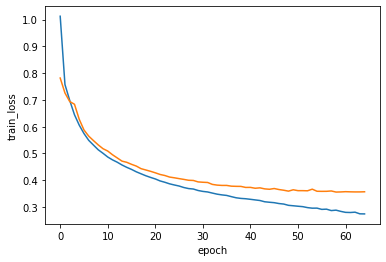

In [134]:
visualizer(train_losses,valid_losses)

In [135]:
test=pd.read_csv("/content/drive/MyDrive/vietnamese_students_feedback/raw_dataset/test.csv")

In [136]:
test_x=test['sentence'].tolist()
test_y=test['topic'].tolist()

In [137]:
embedding_dim=300
hidden_dim=512
num_vocabs=len(tokens)
num_pos_tags=len(pos_tags)
num_labels=4
drop_rate=0.1
model=BiLSTMClassificier(embedding_dim=embedding_dim,hidden_dim=hidden_dim,num_vocabs=num_vocabs,num_pos_tags=num_pos_tags,drop_rate=drop_rate)#,embedding_weights=weights)

ckpt_path = "/content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/"
max_to_keep=5

ckpt = tf.train.Checkpoint(model=model,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_path, max_to_keep=max_to_keep)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print(f'Loading the latest checkpoint from {ckpt_manager.latest_checkpoint}')
else:
  print('Initializing the new checkpoint')

Loading the latest checkpoint from /content/drive/MyDrive/vietnamese_students_feedback/models/fasttext_bilstm/ckpt-48


In [138]:
test_pred=[]
bar=tqdm(test_x)
for sample in test_x:
  inputs=[create_input_ids(sample)]
  input_ids=tf.constant([i['tokens'] for i in inputs],dtype=tf.int32)
  pos_tag_ids=tf.constant([i['pos_tags'] for i in inputs],dtype=tf.int32)
  
  
  logits=model(input_ids=input_ids,pos_tag_ids=pos_tag_ids,training=False)
  probs=tf.nn.softmax(logits,axis=-1)
  label=tf.argmax(probs,axis=-1)
  test_pred.append(label.numpy())
  bar.update()
  

  0%|          | 0/3166 [00:00<?, ?it/s]

In [139]:
print(classification_report(test_y,test_pred,digits=5))

              precision    recall  f1-score   support

           0    0.87382   0.97074   0.91974      2290
           1    0.77262   0.58217   0.66401       572
           2    0.82895   0.86897   0.84848       145
           3    0.66667   0.16352   0.26263       159

    accuracy                        0.85534      3166
   macro avg    0.78551   0.64635   0.67371      3166
weighted avg    0.84308   0.85534   0.83727      3166

